# Test Modelling

With given dataset, predict the probability of the payment within 90 days!

Data is stored as a small SQLite database stored in attached `dataset.db` file. There are two tables - `dataset` and `metadata`. The data sample spans 1 year and 30k observations.

In [94]:
import sqlite3
import pandas as pd
con = sqlite3.connect('dataset.db')

df_m = pd.read_sql_query('SELECT * FROM metadata;', con)
# df_m

### Some background information on the data

The intended target for prediction is `ct090`, `case_id` is the unique identifier, `keydate` is the point in time when some event has happened in the lifecycle of a case, and also a date relative to which all of the backward looking variables and forward looking targets are calculated. In this case, it's a general purpose propensity to pay model, which means that it is a freshly registered case, where all the relevant data has been gathered and verified. In other words, `keydate` is set a few days after registration, and target `ct090` is checking for outcome in 90 days (`ap090` is a similar regression target), while all the rest of the data is only looking backwards!

Metadata gives some basic description of variables. The general naming convention is based on prefixes that define aggregation levels - `cXXXX` looking at the data of this case only, `dXXXX` looking at other cases of same debtor, `bXXXX` looking at all cases of the debtor, `aXXXX` looking at all the cases on the same address. This is not very relevant for this particular task, but gives some idea of our data setup. Note that this data selection has quite a few variables with the `dXXXX` prefix, which means that this selection is specifically looking at debtors that we already had worked with before, therefore, variable selection is much broader and models are generally better. 

One more tip on interpretation of missing values: if variable is bound by time window, e.g. `d2112 NumberOfCustomerPaymentsInLast12Months`, the `NA` value implies that there never have been any values, while `0` would mean that have been no values within bounding period (in this case 12 months). In other words, `0` and `NA` have different interpretation. It may or may not be relevant, depending on the choice of the modelling approach. 

In [95]:
# Exploring the database. 
# Reading the complete variable names.
n0 = print(df_m.name[0])
n16 = print(df_m.name[16])

# Reading some rows of the database. This was useful to help understand the description of each variable name in the metadata
df = pd.read_sql_query('SELECT * FROM dataset;', con)
print(df.head())
# print(df.tail())

# Type of variables
# df.info()
# We hace float64(14), int64(1), object(4).
# case_id is the only int64.
# Keydate, c0039, c0044 y d0012 are objects. The rest are float64.

df.describe()
# Describe is another useful command to get information of the dataframe. It gives an idea of the values in each variable. Also we can 
# see how many nan there are in each column.


RatioOfCustomersAtAddressWithSuccessfullyClosedCasesLast36Months
NumberOfUnsuccessfullyClosedCustomerCasesLast36Months
   case_id                keydate  ct090  ap090   c0001  c0039 c0044  d0031  \
0        1  2017-08-12 00:00:00.0    0.0    0.0  221.68  K6622     1    2.0   
1        2  2017-02-03 00:00:00.0    0.0    0.0  151.36  K6512     2    NaN   
2        3  2017-02-17 00:00:00.0    0.0    0.0   48.84  K6512     3    1.0   
3        4  2017-09-18 00:00:00.0    0.0    0.0  413.15  K6622     4    NaN   
4        5  2017-07-22 00:00:00.0    0.0    0.0  125.83  K6512     5    2.0   

    b0007   d0009  c0031  a8404  c0019  d0027  c9008  d2112 d0012  d1205  \
0    0.00  238.38    2.0    NaN   98.0    0.0   49.0    0.0     1    NaN   
1  210.53    0.00    5.0    NaN  109.0    2.0   51.0    0.0     2    1.0   
2     NaN    0.00    2.0    0.0  748.0    0.0   48.0    NaN     3    NaN   
3     NaN   54.14    3.0    1.0    8.0    0.0   27.0    NaN     4    NaN   
4   20.00   83.00    6.0  

,case_id,ct090,ap090,c0001,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
count,30000.000000,30000.000000,30000.000000,29975.000000,17371.000000,13074.000000,30000.000000,30000.000000,19599.000000,30000.000000,30000.000000,27016.000000,13048.000000,8762.000000,30000.000000
mean,15000.500000,0.168733,49.215836,538.590694,1.634391,423.156043,555.063823,3.092900,0.283395,104.948833,0.473067,42.339466,0.935622,0.897170,605.535361
std,8660.398374,0.374522,240.063401,1248.533877,1.318419,902.166491,1939.588574,2.151021,0.312366,196.864753,1.397094,13.215883,1.755761,0.814515,1223.783876
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-319.010000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,145.100000,1.000000,76.000000,0.000000,2.000000,0.000000,10.000000,0.000000,32.000000,0.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,298.720000,1.000000,202.715000,0.000000,3.000000,0.210000,77.000000,0.000000,41.000000,0.000000,1.000000,355.650000
75%,22500.250000,0.000000,0.000000,638.645000,2.000000,500.677500,481.322500,4.000000,0.450000,126.000000,0.000000,51.000000,1.000000,1.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,15.000000,84561.840000


In [96]:
df_m

,varcode,name,var_class,entity_table
0,a8404,RatioOfCustomersAtAddressWithSuccessfullyClose...,variable,address
1,ap090,TargetAmount90Days,target,case
2,c0001,OriginalCapitalOfCaseInvoices,variable,case
3,c0015,AmountOfCase,variable,case
4,c0019,AgeOfDebt,variable,case
5,c0031,NumberOfTelephonesCI,variable,case
6,c0039,IndustryCode,variable,case
7,c0044,ClientName,variable,case
8,c9008,CustomerAge,variable,case
9,ct090,Target90Days,target,case


In [97]:
# Now we build the first model. 
df.columns
df_c = df.dropna(axis = 0)
# As a first aproximation, all the rows with missing values are dropped. 

# Selecting features. c044 (Client's name), d0012(Last original closing code), keydate and case_id, are left out because they shouldn't
# be relevant for the model. c039(Industry Code) is initially left out, but it's possible that the type of business could affect the model.
# ct090 y ap090 are targets.
df_features = ['c0001', 'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 
    'c0019', 'd0027', 'c9008','d2112', 'd1205', 'c0015']
X = df_c[df_features]

X.describe()
# We can see there are only left 2081 rows of 30k. That's losing a lot of information.

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

y = df_c.ct090
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 1)
model = RandomForestRegressor(n_estimators = 10 , random_state = 1)
model.fit(train_X,train_y)

# print('These are the first 5 debtors: ')
# print(val_X.head())
print('The predictions are ')
preds = model.predict(val_X.head())
print(preds)
print('The Mean Absolute Error is ')
print(mean_absolute_error(val_y.head(), preds))
print('Target value: ')
print(val_y.head())


# MAE here is 0.32. We'll try to improve that in the next steps

The predictions are 
[0.4 0.  0.3 0.2 0.1]
The Mean Absolute Error is 
0.32
Las variables realmente son 
28567    0.0
19549    0.0
16598    0.0
9001     1.0
28254    0.0
Name: ct090, dtype: float64


[0.272552783109405, 0.29059500959692897, 0.28925143953934745, 0.29584133077415226, 0.29520153550863726, 0.2928342930262316, 0.28974194924290897, 0.2895073576455534, 0.29095489443378114, 0.29126679462571975, 0.29181062060140756, 0.2912942144228133, 0.2917226487523992, 0.2922158242695671, 0.29262955854126677, 0.2929494561740243, 0.2930326295585413]
[1, 5, 10, 15, 20, 30, 45, 60, 80, 100, 120, 140, 160, 180, 200, 300, 500]
[0.272552783109405, 0.18863723608445299, 0.1717274472168906, 0.16917892940925572, 0.1666890595009597, 0.16253145660055449, 0.1595820004265302, 0.15885796545105565, 0.15984195057581574, 0.15975681381957774, 0.15964518020899976, 0.15952299345841986, 0.15963396713051822, 0.15996078291983604, 0.16000230326295584, 0.1596970782682875, 0.15983867178502878]


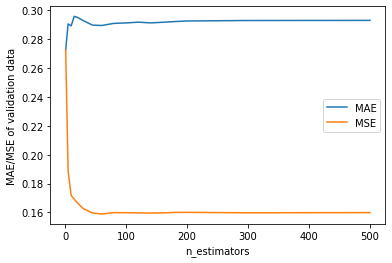

In [98]:
# Plotting the mean absolute and squared error, to check if we can find the right number of trees 

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

mae = []
mse = []
list_nb_trees = [1, 5, 10, 15, 20, 30, 45, 60, 80, 100, 120, 140, 160, 180, 200, 300, 500]

for nb_trees in list_nb_trees:
    model = RandomForestRegressor(n_estimators = nb_trees, random_state = 2)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae.append(mean_absolute_error(val_y, preds_val))
    mse.append(mean_squared_error(val_y, preds_val))
print(mae)
print(list_nb_trees)
print(mse)

plt.plot(list_nb_trees, mae, label = 'MAE')
plt.plot(list_nb_trees, mse, label = 'MSE')
plt.ylabel('MAE/MSE of validation data')
plt.xlabel('n_estimators')
plt.legend(loc = 'center right')
plt.show()

# In the graph, we can see the error get's the lowest values under 100. Checking the list tree, it corresponds to the 6th number, meaning
# the lowest error was using around 30 trees.

In [99]:
# Data cleaning. When exploring the data, we saw there were some columns with a nan values. Using imputation, changing nan values to zero 
# and transforming c0039 to a categorical variable, we'll try to improve.

# df.columns
# All the variables are:
#   ['case_id', 'keydate', 'ct090', 'ap090', 'c0001', 'c0039', 'c0044', 
#   'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 'c0019', 'd0027', 'c9008',
#   'd2112', 'd0012', 'd1205', 'c0015']
df_full = df


# The columns c001 (original capital of case), c0015 (amount of the case), c0019 (age of the case), c9008 (customer age) and 
# b0007 (amount of customer payment in all cases) all have numeric values. To avoid nan values, the mean value of each column is imputed.
imp_cols = ['c0001', 'c0015', 'c0019', 'c9008', 'b0007']
df_imp = df[imp_cols]
# print(df_imp.describe())

from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
imputed_cols = pd.DataFrame(imputer.fit_transform(df_imp))
imputed_cols.columns = df_imp.columns
df_full[imp_cols] = imputed_cols[imp_cols]
# print(df_imp.describe())


# Columns d0031 (Number of unsuccesfully closed cases in the last 36 months), a8404 (Ratio of successfully closed cases in the last 36 months), d2112 (Number of customer 
# payments in the last 12 months) and d1205 (Number of successfully closed cases in the last 24 months) have nan values aswell. This time, I consider that a nan value is 
# the same as a 0. Not having an event outside the time window, is still 0 events during the indicated time.

fill_cols = ['d0031', 'a8404', 'd2112', 'd1205']
df_fill = df[fill_cols]
df_fill = df_fill.fillna(0)
df_full[fill_cols] = df_fill[fill_cols]
# print(df_fill.describe())


# Variable c0039 could be valuable for the model, so I convert it to a categorical variable.

enc_cols = ['c0039']
df_enc = df[enc_cols]
# encoded_cols.describe()

from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
encoded_cols = pd.DataFrame(ordinal_encoder.fit_transform(df_enc))
encoded_cols.columns = df_enc.columns
df_full[enc_cols] = encoded_cols[enc_cols]

df_full.describe()
# After all this data cleaning, we recover all the 30k rows and can be used for the model.

,case_id,ct090,ap090,c0001,c0039,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,0.168733,49.215836,538.590694,5.524000,0.946367,423.156043,555.063823,3.092900,0.185142,104.948833,0.473067,42.339466,0.406933,0.262033,605.535361
std,8660.398374,0.374522,240.063401,1248.013529,1.386202,1.287483,595.553709,1939.588574,2.151021,0.286242,196.864753,1.397094,12.541378,1.247340,0.600153,1223.783876
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-319.010000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,145.157500,5.000000,0.000000,264.282500,0.000000,2.000000,0.000000,10.000000,0.000000,33.000000,0.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,299.020000,5.000000,1.000000,423.156043,0.000000,3.000000,0.000000,77.000000,0.000000,42.339466,0.000000,0.000000,355.650000
75%,22500.250000,0.000000,0.000000,638.015000,7.000000,1.000000,423.156043,481.322500,4.000000,0.320000,126.000000,0.000000,50.000000,0.000000,0.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,7.000000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,15.000000,84561.840000


In [100]:
# Some more data cleaning.

# After observing some values in the feature c001 (original capital of case) I noticed there are some 0 values, while having greater than zero value in the corresponding 
# c0015 (amount of the case) cell. We could consider this an error in the database, as there should be an original capital of case value, if there's a value in the amount of case.
# In the rows affected, c0015 value was copied to c0001.

# ap_max  = pd.read_sql_query('SELECT c0001 FROM dataset WHERE c0001 = 0;', con)
# check1 = df[(df.c0001 == 0) | (df.c0015 == 0)] 
df_full.c0001[df_full.c0001 == 0] = df_full.c0015.copy()


# Also during the observation of the data, I noticed there are 3 negative values in variable d0009 (Amount of customer open cases). It could mean that they have payed more 
# than they should or, it could just be wrong data. I decide to replace those negatives values by 0, considering them errors.

con = sqlite3.connect('dataset.db')
df_d0009 = pd.read_sql_query('SELECT d0009 FROM dataset WHERE d0009 < 0;', con)
print(df_d0009)

df_full.d0009 = df_full.d0009.apply(lambda x : x if x >= 0 else 0)
df_full.describe()
# Now the min value in describe is 0, not -319.

    d0009
0  -63.56
1 -133.20
2 -319.01


C:\Users\garci\AppData\Local\Temp/ipykernel_4928/3369182189.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full.c0001[df_full.c0001 == 0] = df_full.c0015.copy()


,case_id,ct090,ap090,c0001,c0039,d0031,b0007,d0009,c0031,a8404,c0019,d0027,c9008,d2112,d1205,c0015
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,0.168733,49.215836,560.059860,5.524000,0.946367,423.156043,555.081015,3.092900,0.185142,104.948833,0.473067,42.339466,0.406933,0.262033,605.535361
std,8660.398374,0.374522,240.063401,1250.511951,1.386202,1.287483,595.553709,1939.582593,2.151021,0.286242,196.864753,1.397094,12.541378,1.247340,0.600153,1223.783876
min,1.000000,0.000000,0.000000,0.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,6.000000,0.000000,0.000000,9.750000
25%,7500.750000,0.000000,0.000000,156.097500,5.000000,0.000000,264.282500,0.000000,2.000000,0.000000,10.000000,0.000000,33.000000,0.000000,0.000000,185.410000
50%,15000.500000,0.000000,0.000000,316.630000,5.000000,1.000000,423.156043,0.000000,3.000000,0.000000,77.000000,0.000000,42.339466,0.000000,0.000000,355.650000
75%,22500.250000,0.000000,0.000000,668.745000,7.000000,1.000000,423.156043,481.322500,4.000000,0.320000,126.000000,0.000000,50.000000,0.000000,0.000000,725.480000
max,30000.000000,1.000000,25000.000000,84561.840000,7.000000,15.000000,53982.610000,110158.640000,35.000000,1.000000,6193.000000,40.000000,117.000000,24.000000,15.000000,84561.840000


In [101]:
# Building a new model.
# Now that we have imputed or filled all the columns, we train a new model, to see if we get better predictions.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

df_features = ['c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 
    'c0019', 'd0027', 'c9008','d2112', 'd1205', 'c0015']
X = df_full[df_features]

y = df_full.ct090
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 2)
model = RandomForestRegressor(n_estimators = 35, random_state = 2)
model.fit(train_X,train_y)

# print('These are the first 5 debtors ')
# print(val_X.head())
print('Mean Absolute Error: ')
print(mean_absolute_error(val_y.head(), preds))
print('Predictions: ')
preds = model.predict(val_X.head())
print(preds)

print('Target value: ')
print(df_full.ct090.loc[10747], df_full.ct090.loc[12573], df_full.ct090.loc[29676], 
    df_full.ct090.loc[8856], df_full.ct090.loc[21098])

# It's interesting to use cross validation to better determine the error. In some cases, it could take much more time than just the MAE for the selected train-test separation.
scores = cross_val_score(RandomForestRegressor(n_estimators = 45 ,random_state = 2), X, y, scoring='neg_mean_absolute_error')
# print(scores)
print('Cross validation MAE %2f' %(-1 * scores.mean()))

# Mae is around 0.2 which is a better result than 0.32 in the previous model  
# This time, we're using cross validation, that returns an error up to 0.264, but it's a more accurate erorr.

Mean Absolute Error: 
0.19999999999999998
Predictions: 
[0.         0.         0.2        0.48571429 0.11428571]
Target validation value: 
0.0 0.0 0.0 1.0 0.0
Cross validation MAE 0.263954


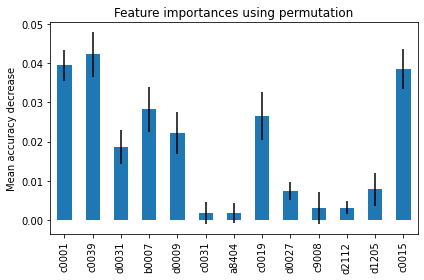

In [102]:
# Feature permutation
# To have a better idea of how important are the features in the model, we can use the feature permutation over the previous model.

from sklearn.inspection import permutation_importance
result = permutation_importance(model, val_X, val_y, n_repeats = 50, random_state = 1, n_jobs = 2)
forest_importances = pd.Series(result.importances_mean, index = df_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = result.importances_std, ax = ax)
ax.set_title('Feature importances using permutation')
ax.set_ylabel('Mean accuracy decrease')
fig.tight_layout()
plt.show()

# We can notice that features  c0031, a8404, d0027, c9008, d2112 and d1205 dont have much weight in the model. They could probably be off the model.

In [103]:
# Building a new model. Leaving out those variables that didn't have much weight in the permutation check.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# (previously used) df_features = ['c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 
    # 'c0019', 'd0027', 'c9008', 'd2112', 'd1205', 'c0015']
# Now leaving out of the model c0031, a8404, d0027, c9008, d2112 and d1205.
df_features = ['c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0019', 'c0015']
X = df_full[df_features]

y = df_full.ct090
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 2)
model = RandomForestRegressor(n_estimators = 35 ,random_state = 2)
model.fit(train_X,train_y)

# print('These are the first 5 debtors ')
# print(val_X.head())
print('Mean Absolute Error: ')
print(mean_absolute_error(val_y.head(), preds))
print('Predictions: ')
preds = model.predict(val_X.head())
print(preds)

print('Target value: ')
print(df_full.ct090.loc[10747], df_full.ct090.loc[12573], df_full.ct090.loc[29676], 
    df_full.ct090.loc[8856], df_full.ct090.loc[21098])

scores = cross_val_score(RandomForestRegressor(n_estimators = 35, random_state = 2), X, y, scoring='neg_mean_absolute_error')
# print(scores)
print('Cross validation MAE %2f' %(-1 * scores.mean()))

# This time MAE is 0.16, which is the best result so far, but cross validation returns an error of 0.259, meaning there's not that much improvement in comparison to the last model.

Mean Absolute Error: 
0.16
Predictions: 
[0.         0.         0.42857143 0.25714286 0.14285714]
Target validation value: 
0.0 0.0 0.0 1.0 0.0
Cross validation MAE 0.259897


['ct090', 'c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 'c0019', 'd0027', 'c9008', 'd2112', 'd1205', 'c0015']


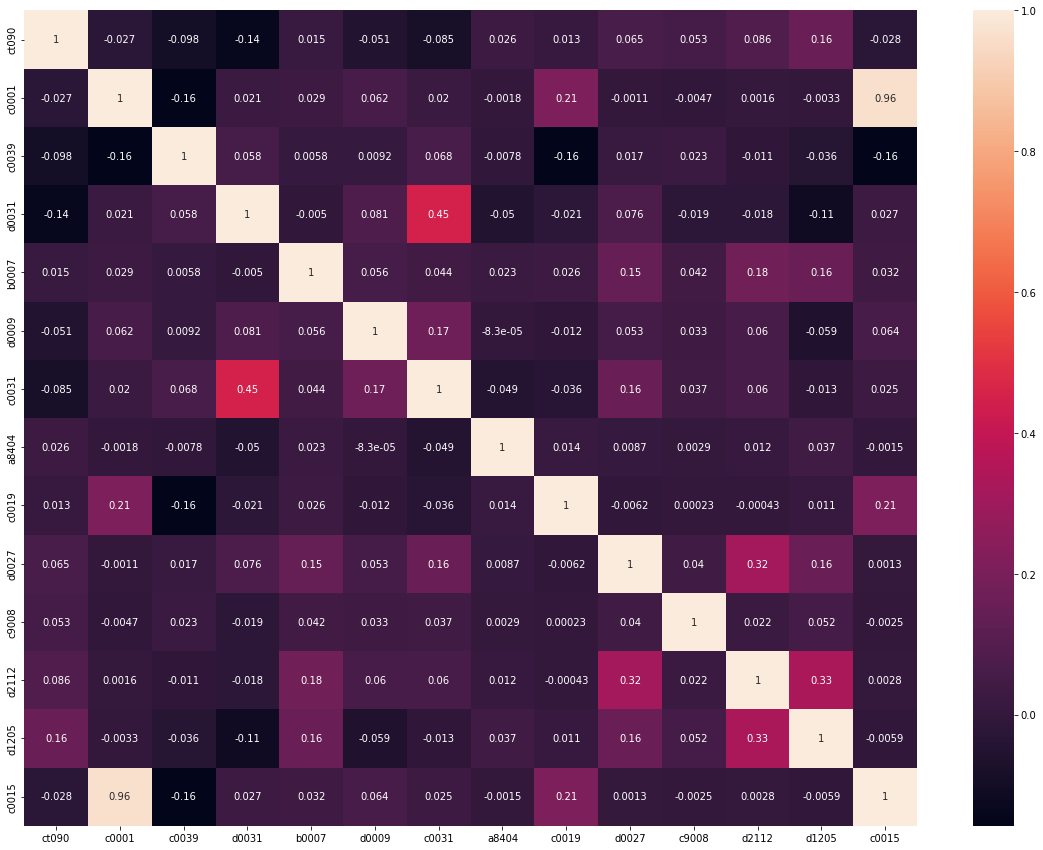

In [104]:
# Correlation matrix.
# We'll check again to see what variable the correlation matrix indicates shows as important. These should be the ones that have high Pearson coefficient, while the ones
# with low coefficient, shouldn't influence much the variability in the other columns.
import seaborn as sns
df_cols = ['ct090', 'c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0031', 'a8404', 
    'c0019', 'd0027', 'c9008','d2112', 'd1205', 'c0015']
print(df_cols)
corr_matrix = df_full[df_cols].corr()

plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [105]:
cor_target = abs(corr_matrix['ct090'])
relevant_features = cor_target[cor_target > 0.1]
print('High correlation variables: ')
print(relevant_features.sort_values())

print('Low correlation variables: ')
to_drop = cor_target[cor_target < 0.1]
print(to_drop.sort_values())
# print(forest_importances)

# Observing this results, we might include in the model high correlation variables. These are d0031 (number of unsuccessfully closed cases in the last 36 months) and 
# d1205 (Number of successfully closed cases in the last 24 months).Both variables could add valuable information to the model, even if they 
# didn't seem to affect much after the permutation check. D0031 was already in the model, but d1205 wansn't. In the next model it will be back to the used features.

High correlation variables: 
d0031    0.139542
d1205    0.155510
ct090    1.000000
Name: ct090, dtype: float64
Low correlation variables: 
c0019    0.013104
b0007    0.015347
a8404    0.026011
c0001    0.027436
c0015    0.027784
d0009    0.051488
c9008    0.053343
d0027    0.064621
c0031    0.085084
d2112    0.085635
c0039    0.097627
Name: ct090, dtype: float64


In [106]:
# Building a new model.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


# # df_features = ['c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0019', 'c0015']   
# This are the features used in the previous model, that left out c0031, a8404, d0027, c9008, d2112 and d1205.
df_features = ['c0001', 'c0039', 'd0031', 'b0007', 'd0009', 'c0019', 'c0015', 'd1205']       # This are the features used now, including d1205.
X = df_full[df_features]

y = df_full.ct090
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 2)
model = RandomForestRegressor(n_estimators = 40 , random_state = 2)
model.fit(train_X,train_y)

# print('These are the first 5 debtors ')
# print(val_X.head())
print('Mean Absolute Error: ')
print(mean_absolute_error(val_y.head(), preds))
print('Predictions: ')
preds = model.predict(val_X.head())
print(preds)

print('Target validation value: ')
print(df_full.ct090.loc[10747], df_full.ct090.loc[12573], df_full.ct090.loc[29676], 
    df_full.ct090.loc[8856], df_full.ct090.loc[21098])

scores = cross_val_score(RandomForestRegressor(n_estimators = 45, random_state = 2), X, y, scoring = 'neg_mean_absolute_error')
# print(scores)
print('Cross validation MAE %2f' %(-1 * scores.mean()))

# Finally, after including variable d1205, MAE and cross validation errors were almost the same, so I don't consider important to include the variable. 
# Some tests were also made, leaving out of the model variables with low correlation value like c0019, b0007, a8404, c0001 or c0015, but the cross validation error 
# remained around 0.26, so the existing model was probably as good as this last one.

# Alejandro García Lagos

Mean Absolute Error: 
0.1657142857142857
Predictions: 
[0.    0.025 0.35  0.55  0.2  ]
Target validation value: 
0.0 0.0 0.0 1.0 0.0
Cross validation MAE 0.260107
